# COGS 108 - EDA Checkpoint

# Names

- Clara Yi
- Ernest Lin
- Wesley Nguyen
- Ethan Lee
- Stephen Kim

<a id='research_question'></a>
# Research Question

Do the macroscopic socioeconomic features of a state, specifically median income, percentage of population without health insurance, and prevalence of blue collar workers, have a correlation to COVID infection and mortality rates in 2020-2021?

# Setup

In [49]:
# these installations are not directly related to our EDA, but the necessary packages throughout all steps of our project. There are EDA-specific installations later.
# pip initial installation
!pip3 install pandas
!pip install pandas
!pip3 install matplotlib
!pip3 install seaborn
!pip3 install openpyxl
!pip3 install sklearn
!pip3 install patsy 
!pip3 install statsmodels
!pip3 install openpyxl

#importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
import statsmodels.api as sm
import patsy

You should consider upgrading via the 'C:\Python\Python39\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Python\Python39\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Python\Python39\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Python\Python39\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Python\Python39\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Python\Python39\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Python\Python39\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Python\Python39\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Python\Python39\python.exe -m pip install --upgrade pip' command.


# Data Cleaning

## Dataset 1 (COVID)
- With the imported data, we removed unncessary states. We only want the 50 states not including territories or DC
- We then removed the columns that we didn't need for analysis. We did this by selecting the columns that we needed
- We also wanted the dates to appear in a sortable/searchable way, so we made the dates arranged in yyyy-mm-dd format
- The data was then saved as a csv file.

**Note**: Since the data is arranged by date, we created a function ```read_covid_data``` that will return the 50 states with their respective data for just that specified date

## Dataset 1 (COVID) Code

In [50]:
# Cleaning State Data
def clean_covid_data():
    # Date Closure
    def apply_date(date: str) -> str:
        split_date = date.split("/")
        return "/".join([split_date[2], split_date[0], split_date[1]])
        
    
    # Read the data (already in tabular form)
    covid_data_url = r"./Raw Data/United_States_COVID-19_Cases_and_Deaths_by_State_over_Time.csv"
    covid_data = pd.read_csv(covid_data_url)
    
    # States we will not be looking at (These aren't part of the 50 states)
    remove_states = ["RMI", "FSM", "GU", "MP", "PW", "NYC", "PR", "AS", "VI", "DC"]
    covid_data = covid_data[~covid_data["state"].isin(remove_states)]
    
    # Remove columns we don't need
    covid_data = covid_data[["submission_date", "state", "tot_cases", "tot_death"]]
    
    # Change Date format to allow for easier sorting
    covid_data["submission_date"] = covid_data["submission_date"].apply(apply_date)
    
    # Sort Date
    covid_data.sort_values("submission_date", inplace=True, ascending=False)
    covid_data.reset_index(inplace=True, drop=True)
    
    # Save Data
    clean_covid_data_url = r"Cleaned Data/state_covid_data.csv"
    covid_data.to_csv(clean_covid_data_url, index=False)
    
clean_covid_data()

In [51]:
def read_covid_data(month: int, day: int, year: int):
    #retrieve cleaned csv
    covid_data_url = r"Cleaned Data/state_covid_data.csv"
    covid_data = pd.read_csv(covid_data_url)
    
    #reformat date parameter to match data values in csv, then get all data from specific date
    date_filter = formatDate(month, day, year)
    covid_data = covid_data[covid_data["submission_date"] == date_filter]
    covid_data.sort_values("state", inplace=True)
    covid_data.reset_index(inplace=True, drop=True)
    
    return covid_data

def formatPreZero(num: int) -> str:

    #adds '0' char to any integer less than 10 to match formatting
    if num >= 10:
        return str(num)
    
    return "0" + str(num)
    
#reformat date parameter to match data values in csv    
def formatDate(month: int,  day: int, year: int) -> str:
    return f"{year}/{formatPreZero(month)}/{formatPreZero(day)}"

## Dataset 2 (Labor)
- The raw data file for Dataset 2 is an excel file. The format of the data was not organized in a way that complements dataframes, so we had a lot of unnecessary texts in the excel
read as data entries as well. 
- Our first step was to identify the columns and rows that we want, which are the 50 states. We removed unnecessary states (including U.S. territories) and removed all the extra
non-state entries that were read as rows.
- Another problem is that some names in the State column had some footnote numbers that were unintentionally read from the excel sheet. We solved this by removing all occurences of numbers and parentheses from the State column.
- Since other datasets use state codes and the original data uses state names, we had to transform state names in the States column to their corresponding state codes. We did this by defining a function ```to_state_code``` that uses a dictionary to map each state name to their state code.
- We had to reorganize the structure of the dataframe, as the original file had the data stacked on top of each other so each state had 3 rows in the Dataframe. We did so by separating the 
raw dataframe into three different dataframes, and then combining them into a single dataframe so we only have 50 rows.
- We then removed unnessary columns, such as data from other time periods (Our focus was December of 2020). We also combined the columns of job sectors into two groups relevant to our analysis: Blue collar (construction, mining, trade, leisure) and White collar (Financial, professional, education, government) jobs.
- Our final step for Dataset 3 is to export the cleaned dataset as a csv and save it to the "Cleaned Data" folder.

## Dataset 2 (Labor) Code

In [52]:
#Copied from https://gist.github.com/rogerallen/1583593
us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "District of Columbia": "DC",
    "American Samoa": "AS",
    "Guam": "GU",
    "Northern Mariana Islands": "MP",
    "Puerto Rico": "PR",
    "United States Minor Outlying Islands": "UM",
    "U.S. Virgin Islands": "VI",
}

def to_state_code(state_name):
    return us_state_to_abbrev[state_name]

In [53]:
def clean_labor_data():
    #Read excel file, renames first column to States and take out null rows
    raw_labor_data = pd.read_excel("./Raw Data/labor_dataset_raw.xlsx", header = 4, engine = "openpyxl")
    raw_labor_data.rename(columns={"Unnamed: 0": "State"}, inplace=True)
    raw_labor_data = raw_labor_data.dropna()

    #Take out data from 2021 and only keep 2020
    raw_labor_data = raw_labor_data[["State", "Dec.\n2020", "Dec.\n2020.1", "Dec.\n2020.2"]]
    
    non_states = ["Virgin Islands", "District of Columbia", "Puerto Rico"]

    #Removes all non official states from dataset
    for region in non_states:
        raw_labor_data = raw_labor_data[raw_labor_data["State"].str.contains(region)==False]

    #Reset index to start at 0
    raw_labor_data = raw_labor_data.reset_index(drop = True)

    #eliminated extra characters in state names
    raw_labor_data["State"] = raw_labor_data["State"].str.replace('\d+', '', regex=True)
    raw_labor_data["State"] = raw_labor_data["State"].str.replace('(', '', regex=True)
    raw_labor_data["State"] = raw_labor_data["State"].str.replace(')', '', regex=True)

    #Convert state names into codes (First two letters of each state name)
    raw_labor_data["State"] = raw_labor_data["State"].apply(lambda state_name: us_state_to_abbrev[state_name])

    #Original raw data has different columns stacked on top of each row, so we need to reorder the dataset.
    #Block 1 contains total, constructing and mining data
    block1 = raw_labor_data[:50]
    block1.columns = ["State", "Total", "Constructing", "Mining"]

    #Block 2 contains Trade, Financial and Professional
    block2 = raw_labor_data[50:100]
    block2.columns = ["State", "Trade", "Financial", "Professional"]

    #Block 3 contains Education, Leisure and Government
    block3 = raw_labor_data[100:]
    block3.columns = ["State", "Education", "Leisure", "Gov"]

    #merge all blocks into one dataframe
    labor_data = block1.merge(block2, on="State")
    labor_data = labor_data.merge(block3, on="State")

    #We only need data on white collar and blue collar, so we can combine each job sector to their respective group.
    labor_data["Blue_col"] = labor_data["Constructing"] + labor_data["Mining"] + labor_data["Trade"] + labor_data["Leisure"]
    labor_data["White_col"] = labor_data["Financial"] + labor_data["Professional"] + labor_data["Education"] + labor_data["Gov"]

    #Get rid of all other columns except State, White_col, Blue_col and Total
    labor_data.drop(columns = ["Constructing", "Mining", "Trade", "Financial", "Professional", "Education", "Leisure", "Gov"], inplace=True)
    #export as csv
    labor_data.columns = ['state','tot_jobs','blue_col','white_col']
    labor_data.to_csv('./Cleaned Data/state_labor_data.csv')

def get_labor_data():
    labor_data_url = './Cleaned Data/state_labor_data.csv'
    labor_data = pd.read_csv(labor_data_url)
    return labor_data

clean_labor_data()


## Dataset 3 (Income/Insurance)
- For Dataset 3, we have two primary steps in cleaning the data. The first step was manually inputting the data from the data sources to a CSV file via Google Sheets. This manual step was necessary due to the fact that the original data source did not have an option to directly extract/download the raw data. Since there were only 50 observations, we decided manual input was the best option. 

- Our second step for Dataset 3 was to import the data into this notebook. We uploaded the CSV file into our "Raw Data" folder, and then used read_csv to bring it into a dataframe, which is a usable format for our future analysis. After making sure there were no issues, we then saved it to the "Cleaned Data" folder.

## Dataset 3 (Income/Insurance) Code

In [54]:
def standardize_income(string):
    string = string.strip()

    string = string.replace(',', '')
    return float(string)

# Cleaning socioeconomic data
def clean_socioeconomic_data():
    socioeconomic_data_url = r'./Raw Data/socioeconomic_data.csv'
    soci_data = pd.read_csv(socioeconomic_data_url)

    #simplify columns and replace Median Household income values with floats
    soci_data.columns = ['state', '%_no_insurance', 'median_income']
    soci_data['median_income'] = soci_data['median_income'].apply(standardize_income)

    soci_data['with_insurance'] = 100 - soci_data['%_no_insurance'] 

    # Saving to CSV
    clean_socioeconomic_data_url = r"./Cleaned Data/clean_socioeconomic_data.csv"
    soci_data.to_csv(clean_socioeconomic_data_url, index=False)
    
def get_socioeconomic_data():
    clean_socioeconomic_data_url = r"./Cleaned Data/clean_socioeconomic_data.csv"
    soci_data = pd.read_csv(clean_socioeconomic_data_url)
    return soci_data

clean_socioeconomic_data()

## Dataset 4 (US population)
- The raw data is in csv format with population census data from the US government. For our purposes, we only want the state name and the population in 2020. Although it is 2022, there is not yet a fully released dataset on 2021 population data aside from estimates, so it is fine that we only have 2020 populations and we will be conducting our analysis for 2020.

- Since there are also US territories included and DC, we remove those unwanted rows. We also want to store states as their state code rather than their full name. There are also problems with having the population stored as a string, so we do some formatting to make the population be stored as an integer. Finally, we apply some renaming and then our data cleaning is complete.

https://data.ers.usda.gov/reports.aspx?ID=17827

## Dataset 4 (US population) Code

In [55]:
def clean_population_data():
    def format_population(pop: str) -> int:
        pop = pop.replace(",", "")
        return int(pop)
    # get population data
    population_data_url = r"Raw Data/PopulationReport.csv"
    pop_data = pd.read_csv(population_data_url)
    
    # keep only state name and total population 2020
    pop_data = pop_data[["Name", "Pop. 2020"]]
    
    # Remove unwanted Rows
    remove_rows = ["United States", "District of Columbia", "Puerto Rico", "Source: U.S. Census Bureau, 1990, 2000, 2010, 2020 Censuses of Population\n\n\n"]
    pop_data = pop_data[~pop_data["Name"].isin(remove_rows)]
    pop_data.dropna(inplace=True)
    
    # Change column name
    pop_data.columns = ["state", "total_population"]
    
    # Value formatting
    pop_data["total_population"] = pop_data["total_population"].apply(format_population)
    pop_data["state"] = pop_data["state"].apply(to_state_code)
    
    # save to cleaned data
    cleaned_population_data_url = "Cleaned Data/population.csv"
    pop_data.to_csv(cleaned_population_data_url, index=False)
    
def read_population_data():
    cleaned_population_data_url = "Cleaned Data/population.csv"
    pop_data = pd.read_csv(cleaned_population_data_url)
    return pop_data

clean_population_data()

# Data Analysis & Results (EDA)

Our EDA involves both univariate and multivariate data-viz techniques. The following is a brief summary of our EDA, but the comments scattered throughout the code are helpful to understand our results. One important thing to note is that for the COVID data, we added up the number of cases and infections throughout the 2020 year to get the proper counts. On the other hand, our other 3 datasets are instantaneously recorded, showing a snapshot of one point in time that represents 2020.

### Size
At the end of our data cleaning, we ended up with 4 dataframes with 50 rows each. The rows were made unique by their state identifier. The state identifiers are two-letter abberviations of the state that each row represents. We used these 4 dataframes and merged them into one using the following functions.

#### Imports

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
import statsmodels.api as sm
import patsy

#### Functions to Merge DataFrames

In [57]:
def formatPreZero(num: int) -> str:

    #adds '0' char to any integer less than 10 to match formatting
    if num >= 10:
        return str(num)
    
    return "0" + str(num)
    
#reformat date parameter to match data values in csv    
def formatDate(month: int,  day: int, year: int) -> str:
    return f"{year}/{formatPreZero(month)}/{formatPreZero(day)}"

def read_covid_data(month: int, day: int, year: int):
    #retrieve cleaned csv
    covid_data_url = r"Cleaned Data/state_covid_data.csv"
    covid_data = pd.read_csv(covid_data_url)
    
    #reformat date parameter to match data values in csv, then get all data from specific date
    date_filter = formatDate(month, day, year)
    covid_data = covid_data[covid_data["submission_date"] == date_filter]
    covid_data.sort_values("state", inplace=True)
    covid_data.reset_index(inplace=True, drop=True)
    
    return covid_data

#retrieve cleaned labor data, socioeconomic data, and population data frames respectively

def get_labor_data():
    labor_data_url = 'Cleaned Data/state_labor_data.csv'
    labor_data = pd.read_csv(labor_data_url)
    return labor_data

def get_socioeconomic_data():
    clean_socioeconomic_data_url = "Cleaned Data/clean_socioeconomic_data.csv"
    soci_data = pd.read_csv(clean_socioeconomic_data_url)
    return soci_data

def get_population_data():
    cleaned_population_data_url = r"Cleaned Data/population.csv"
    pop_data = pd.read_csv(cleaned_population_data_url)
    return pop_data

#given date parameters, get_overall_data calls functions above and then attempts to merge the resulting dataframes
def get_overall_data(month: int, day:int, year:int):
    covid_data = read_covid_data(month, day, year)
    soci_data = get_socioeconomic_data()
    labor_data = get_labor_data()
    pop_data = get_population_data()

    #merge all dataframes together into a 50 row * 11 col dataframe with key data
    overall_df = pd.merge(labor_data, soci_data, left_on='state', right_on='state')
    overall_df = pd.merge(overall_df, covid_data, left_on='state', right_on='state')
    overall_df = pd.merge(overall_df, pop_data, left_on="state", right_on="state")
    overall_df.drop(["Unnamed: 0"], axis="columns", inplace=True)
    
    #rename first 11 columns
    overall_df.columns = ['state', 'total_jobs', 'blue_collar', 'white_collar', '%_no_insurance', 'median_income', 
                          '%_with_insurance', 'submission_date', 'total_cases', 'total_deaths', "total_population"]

    #add 4 new columns: mortality rate, % of blue/white collar laborers in workforce, and infection rate
    overall_df['%_mortality_rate'] = (overall_df['total_deaths'] / overall_df['total_cases']) * 100
    overall_df['%_blue_collar'] = overall_df['blue_collar'] / overall_df['total_jobs'] * 100
    overall_df['%_white_collar'] = overall_df['white_collar'] / overall_df['total_jobs'] * 100
    overall_df["%_infection_rate"] = (overall_df["total_cases"] / (overall_df["total_population"] - overall_df["total_deaths"])) * 100


    overall_df = overall_df[['state', 'total_jobs', 'blue_collar', '%_blue_collar', 'white_collar', '%_white_collar', 
                            'median_income', '%_no_insurance', '%_with_insurance', 'submission_date', 'total_population', 
                            'total_cases', 'total_deaths',  '%_mortality_rate', '%_infection_rate']]
    return overall_df

In [58]:
#define socioeconomic coefficient (prosperity coefficient)
def calculate_alpha(median_income, with_insurance, white_labor):
    # alpha is the name of our coeff, it takes the three variables and standardizes them, then assigns them equal weight.
    alpha = ((((median_income/100000)*0.3333)) + (with_insurance/100)*0.3333 + (white_labor/100)*0.3333)
    return alpha

#### Calling the functions (Consolidating/Combining Data)

In [59]:
# use get_overall_data
overall_df = get_overall_data(12, 12, 2021)

# create column for calculated coeffeicients
overall_df['coeff'] = calculate_alpha(overall_df['median_income'],overall_df['%_with_insurance'], overall_df['%_white_collar'])

overall_df.head()

,state,total_jobs,blue_collar,%_blue_collar,white_collar,%_white_collar,median_income,%_no_insurance,%_with_insurance,submission_date,total_population,total_cases,total_deaths,%_mortality_rate,%_infection_rate,coeff
0,AL,2012.50,924.90,45.96,968.00,48.10,54393.00,11.70,88.30,2021/12/12,5024279,851857,16505,1.94,17.01,0.64
1,AK,304.10,115.80,38.08,163.20,53.67,74476.00,13.90,86.10,2021/12/12,733391,147975,856,0.58,20.20,0.71
2,AZ,2860.30,1191.20,41.65,1523.60,53.27,66628.00,13.60,86.40,2021/12/12,7151502,1316189,23036,1.75,18.46,0.69
3,AR,1257.50,576.40,45.84,599.20,47.65,50540.00,10.90,89.10,2021/12/12,3011524,538426,8848,1.64,17.93,0.62
4,CA,15937.90,6396.30,40.13,8559.30,53.70,77358.00,8.90,91.10,2021/12/12,39538223,5133238,74509,1.45,13.01,0.74


### A Quick Note on Missingness
None of our required data was missing due to the nature of our source databases. The US Census data requires averages and census information from each state, as well as the CDC. One way we prevented missingness or inconsistency in our data was by eliminating US territories, like Washington DC. However, after the data cleaning portion of our project, we do not have any missing data to deal with.

### Shape
We conduct a series of data vizualization steps to show what our current data looks like. By the way, now might be a good time to take a look at some of the general stats of our dataframe.


In [60]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
overall_df.describe()

,total_jobs,blue_collar,%_blue_collar,white_collar,%_white_collar,median_income,%_no_insurance,%_with_insurance,total_population,total_cases,total_deaths,%_mortality_rate,%_infection_rate,coeff
count,50.00,50.00,50.00,50.00,50.00,50.00,50.00,50.00,50.00,50.00,50.00,50.00,50.00,50.00
mean,2815.70,1181.38,42.68,1468.61,51.42,67909.98,10.08,89.92,6615194.72,968293.84,15126.98,1.47,15.42,0.70
std,3065.36,1244.98,4.05,1647.99,3.89,11519.76,3.57,3.57,7436143.22,1032834.80,16728.21,0.36,3.42,0.05
min,273.70,115.80,31.67,124.30,42.83,44966.00,3.50,79.20,576851.00,51667.00,422.00,0.58,5.93,0.59
25%,776.90,308.90,40.15,394.27,49.01,60100.25,7.62,87.83,1869705.50,314235.50,3737.25,1.24,14.10,0.65
50%,1838.20,845.50,42.94,915.15,50.86,66998.00,9.55,90.45,4581796.50,727499.50,10161.00,1.48,16.36,0.69
75%,3333.93,1423.20,45.27,1877.92,53.69,77157.00,12.17,92.38,7566836.25,1265307.00,18901.25,1.67,17.55,0.74
max,15937.90,6396.30,52.11,8559.30,61.42,94384.00,20.80,96.50,39538223.00,5133238.00,74509.00,2.19,21.51,0.82


## Explanation of Key Variables in Overall Dataframe

**total_jobs** : Total number of employees on nonfarm payrolls, in thousands

**blue_collar**: Total number of employees in construction, mining, trade, and leisure industries, in thousands

**white_collar**: Total number of employees in financial, professional, educational, and government industries, in thousands

**%_blue_collar**: number of blue collar employees / total number of jobs

**%_white_collar**: number of white collar employees / total number of jobs

**median_income**: median individual income, in USD

**%_no_insurance**: % of eligible adults without health insurance

**%_with_insurance**: % of eligible adults with health insurance

**total_population**: total population

**total_cases**: total reported covid-19 cases

**total_deaths**: total reported covid19-related deaths

**%_mortality_rate**: deaths / cases

**%_infection_rate**: cases / total population

**coeff**: a general socioeconomic measure, calculated by equally weighting the median income figure, % with insurance, and rate of white collar labor to generate a value between 0 and 1.

Now that we have more of the general descriptive stats on here, let's look at some of the relationships we can easily visualize between our independent variables (socioeconomic factors) and our dependent variable (COVID data). We can accomplish this using scatterplots.

In [61]:
#print slope/intercept data
def getSiData(slope1, int1, slope2, int2):
    print('SLOPE INTERCEPT DATA:\nLEFT GRAPH: ')
    print('SLOPE: ' + str(slope1) + ' INTERCEPT: ' + str(int1))
    print('\nRIGHT GRAPH: ')
    print('SLOPE: ' + str(slope2) + ' INTERCEPT: ' + str(int2))

#### Scatterplot 1: Relationship between COVID and Median Income

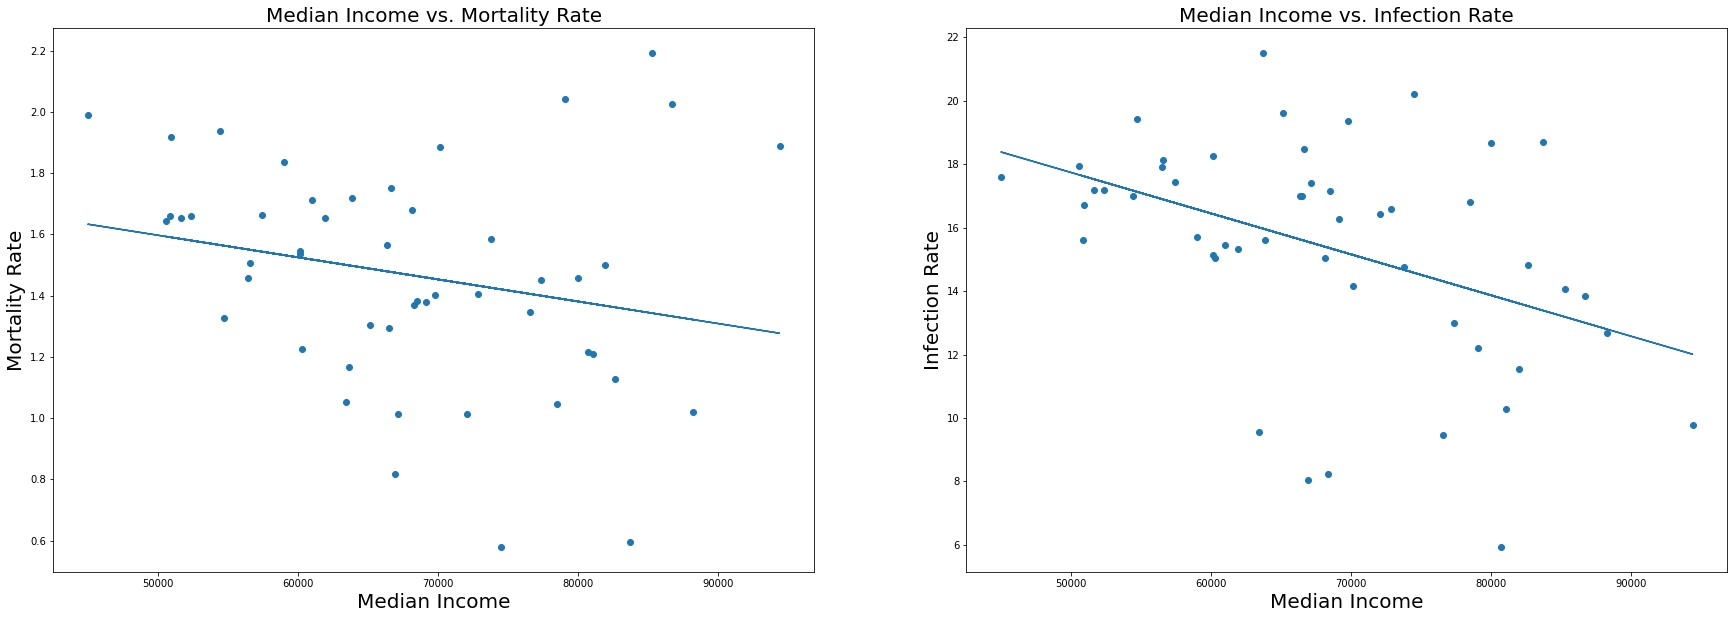

SLOPE INTERCEPT DATA:
LEFT GRAPH: 
SLOPE: -7.206334087726951e-06 INTERCEPT: 1.9570577610053967

RIGHT GRAPH: 
SLOPE: -0.000129026847854884 INTERCEPT: 24.1870746728499


In [62]:
# scatterplot 1 (median_income vs mortality_rate) and (median_income vs infection_rate)

#initialize the figure and scatterplots
fig = plt.figure(figsize = (30, 10))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

a1, b1 = np.polyfit(overall_df['median_income'], overall_df['%_mortality_rate'], 1)
a2, b2 = np.polyfit(overall_df['median_income'], overall_df['%_infection_rate'], 1)


#integrate data from overall_df/data from all states
ax1.scatter(overall_df['median_income'], overall_df['%_mortality_rate'])
ax2.scatter(overall_df['median_income'], overall_df['%_infection_rate'])

#titles and axis labels
ax1.set_title('Median Income vs. Mortality Rate', fontsize = 20)
ax1.set_xlabel('Median Income', fontsize = 20)
ax1.set_ylabel('Mortality Rate', fontsize = 20)

ax2.set_title('Median Income vs. Infection Rate', fontsize = 20)
ax2.set_xlabel('Median Income', fontsize = 20)
ax2.set_ylabel('Infection Rate', fontsize = 20)

ax1.plot(overall_df['median_income'], a1*overall_df['median_income'] + b1)
ax2.plot(overall_df['median_income'], a2*overall_df['median_income'] + b2)
plt.show()

#print slope/intercept data
getSiData(a1, b1, a2, b2)

Each of the scatterplots above contain 50 data points each, with an individual data point representing one state. Thus, the scatterplot on the left contains 50 data points that represent a state's median income and COVID mortality rate while the scatterplot on the right contains 50 data points that represent a state's median income and COVID infection rate. Additionally, no data points are missing as we intentionally chose, cleaned, and analyzed datasets that had data for all 50 states. 

In the code to generate the scatterplots, we used matplotlib and its scatter function to generate the two scatterplots side-by-side. Additionally, we used numpy (np), specifically np.polyfit(), to create the line of best fit for the two scatterplots. Thus, the scatterplot on the left has a line of best fit to represent the relationship between a state's median income and COVID mortality rate. Similarly, the scatterplot on the right has a line of best fit to represent the relationship between a state's median income and COVID infection rate. 

Both of the scatterplots show the same negative, moderate trend. The scatterplot on the left shows that as a state's median income increases, its COVID mortality rate decreases. Similarly, the scatterplot on the right shows that as a state's median income increases, its COVID infection rate decreases. Going back to our research question, these two scatterplots do show that there is a negative correlation between a state's median income and COVID mortality and infection rates. However, we cannot prove causation without performing an experiment. 

One possible explanation for why there is a negative correlation in both scatterplots is that states with higher median incomes means that there are more people with higher incomes. Thus, this higher wealth means that people in these states can afford better healthcare while people in lower-income states might not have access to the same healthcare. Thus, states with a higher median income will tend to have a lower COVID mortality and infection rate since there are more people who can afford healthcare. 

#### Scatterplot 2: Relationship between COVID and Insurance

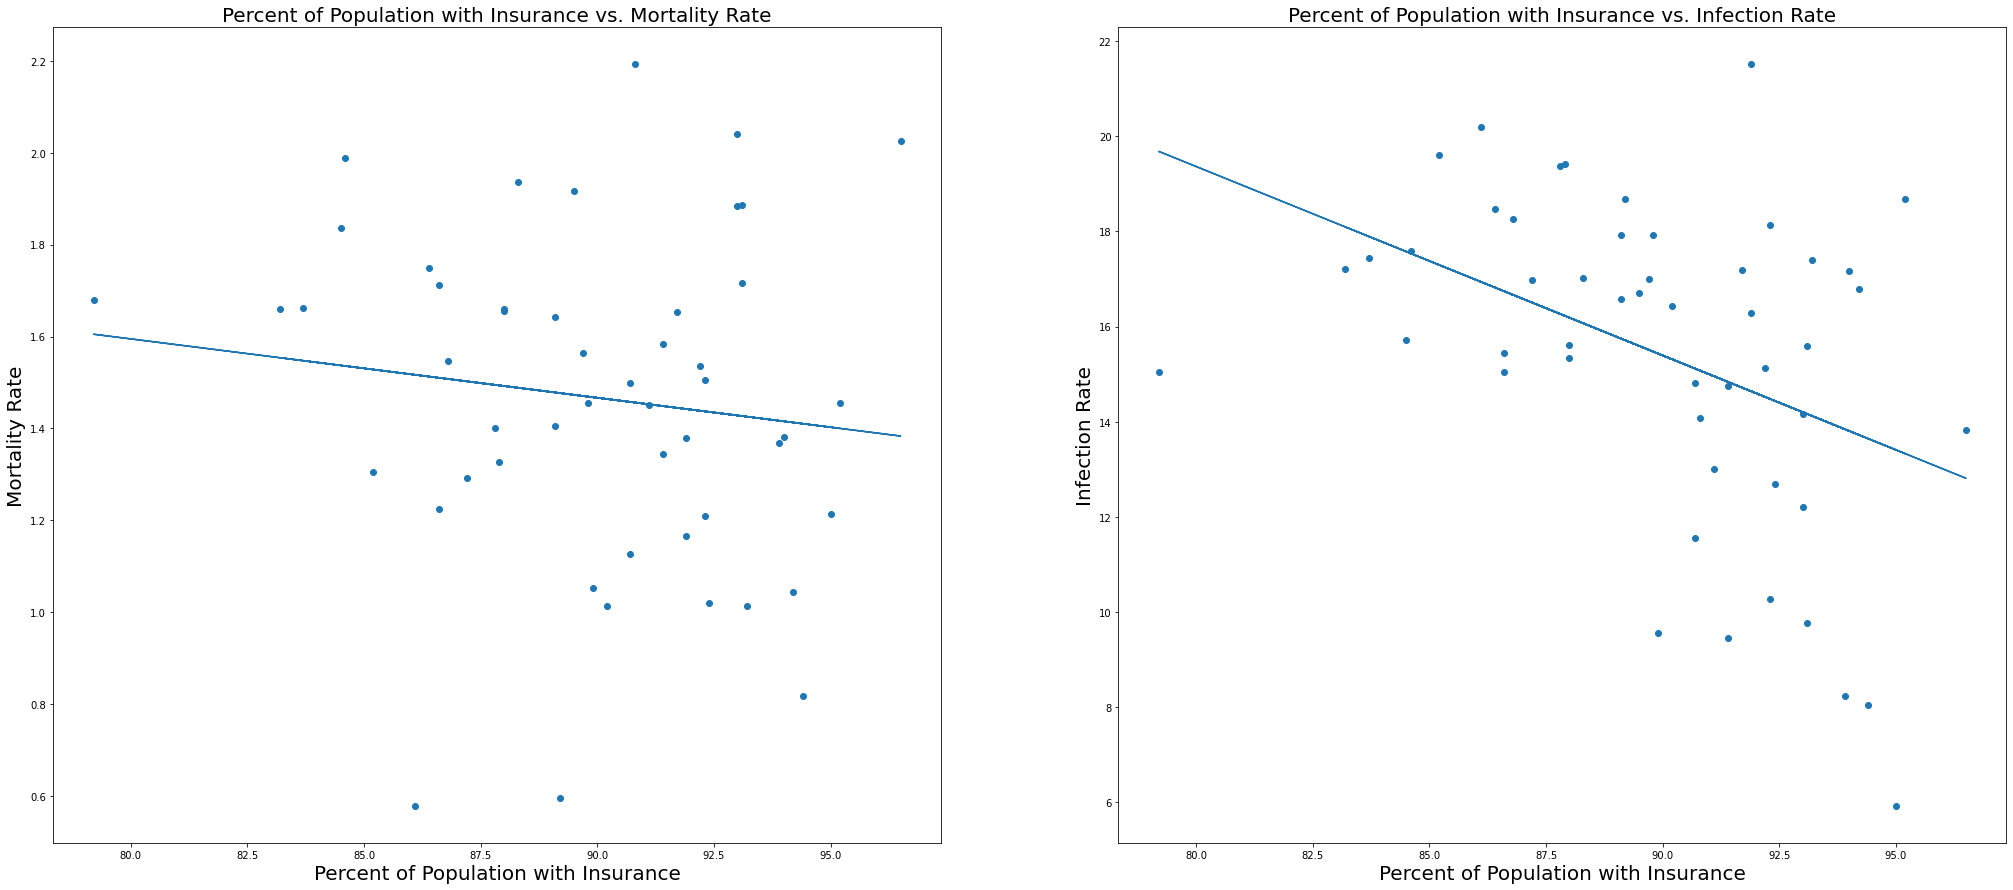

SLOPE INTERCEPT DATA:
LEFT GRAPH: 
SLOPE: -0.012814598848631 INTERCEPT: 2.619964485703441

RIGHT GRAPH: 
SLOPE: -0.3969958372745386 INTERCEPT: 51.12272970328818


In [63]:
# scatterplot 2 (with_insurance vs morality_rate) and (with_insurance vs infection_rate) (wesley)

#initialize the figure and scatterplots
fig2 = plt.figure(figsize = (35, 15))
ax1 = fig2.add_subplot(121)
ax2 = fig2.add_subplot(122)

a1, b1 = np.polyfit(overall_df['%_with_insurance'], overall_df['%_mortality_rate'], 1)
a2, b2 = np.polyfit(overall_df['%_with_insurance'], overall_df['%_infection_rate'], 1)

#integrate data from overall_df/data from all states
ax1.scatter(overall_df['%_with_insurance'], overall_df['%_mortality_rate'])
ax2.scatter(overall_df['%_with_insurance'], overall_df['%_infection_rate'])

#titles and axis labels
ax1.set_title('Percent of Population with Insurance vs. Mortality Rate', fontsize = 20)
ax1.set_xlabel('Percent of Population with Insurance', fontsize = 20)
ax1.set_ylabel('Mortality Rate', fontsize = 20)

ax2.set_title('Percent of Population with Insurance vs. Infection Rate', fontsize = 20)
ax2.set_xlabel('Percent of Population with Insurance', fontsize = 20)
ax2.set_ylabel('Infection Rate', fontsize = 20)


ax1.plot(overall_df['%_with_insurance'], a1*overall_df['%_with_insurance'] + b1)
ax2.plot(overall_df['%_with_insurance'], a2*overall_df['%_with_insurance'] + b2)
plt.show()

#print slope/intercept data
getSiData(a1, b1, a2, b2)

These two scatterplots are very similar to the scatterplots in the previous section that showed a negative correlation between a state's median income and COVID mortality and infection rates. 

Each of the scatterplots above contain 50 data points each, with an individual data point representing one state. Thus, the scatterplot on the left contains 50 data points that represent a state's percentage of people who have health insurance and COVID mortality rate while the scatterplot on the right contains 50 data points that represent a state's percentage of people who have health insurance and COVID infection rate. Additionally, no data points are missing as we intentionally chose, cleaned, and analyzed datasets that had data for all 50 states. 

The scatterplot on the left has a line of best fit to represent the relationship between a state's percentage of people who have health insurance and COVID mortality rate. Similarly, the scatterplot on the right has a line of best fit to represent the relationship between a state's percentage of people who have health insurance and COVID infection rate. 

Both of the scatterplots show the same negative, moderate trend. The scatterplot on the left shows that as a state's percentage of people who have health insurance increases, its COVID mortality rate decreases. Similarly, the scatterplot on the right shows that as a state's percentage of people who have health insurance increases, its COVID infection rate decreases. Going back to our research question, these two scatterplots do show that there is a negative correlation between a state's percentage of people who have health insurance and COVID mortality and infection rates. However, we cannot prove causation without performing an experiment. 

One possible explanation for why there is a negative correlation in both scatterplots is that states with a higher percentage of people with health insurance means that there are more people with access to healthcare. Thus, this higher access means that people in these states can afford better healthcare and get treated for COVID while people in lower-percentage states might not have access to the same healthcare. Thus, states with a higher percentage of people with health insurance will tend to have a lower COVID mortality and infection rate since there are more people who can access healthcare. 

#### Scatterplot 3: Relationship between COVID and Labor Distribution

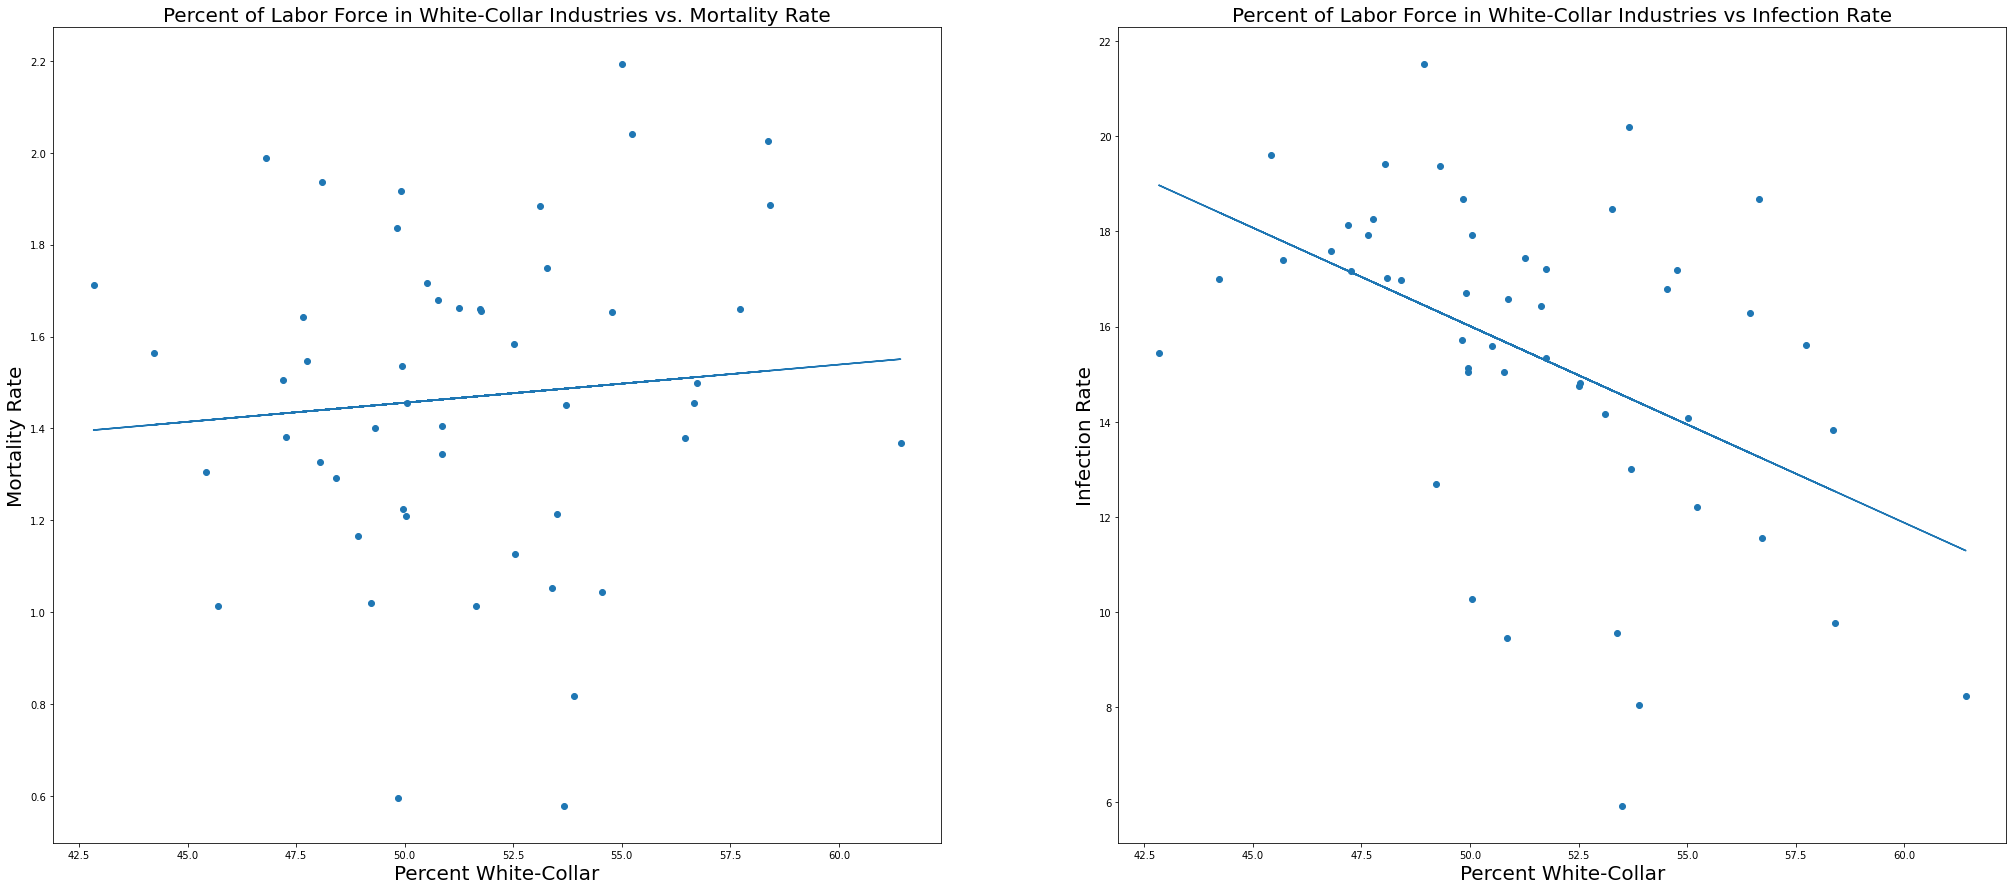

SLOPE INTERCEPT DATA:
LEFT GRAPH: 
SLOPE: 0.008302212311370278 INTERCEPT: 1.040810942162528

RIGHT GRAPH: 
SLOPE: -0.4132225940004615 INTERCEPT: 36.67103064635355


In [64]:
# scatterplot 3 (%_white_collar vs morality_rate) and (%_white_collar vs infection_rate)

#initialize the figure and scatterplots
fig3 = plt.figure(figsize = (35, 15))
ax1 = fig3.add_subplot(121)
ax2 = fig3.add_subplot(122)

a1, b1 = np.polyfit(overall_df['%_white_collar'], overall_df['%_mortality_rate'], 1)
a2, b2 = np.polyfit(overall_df['%_white_collar'], overall_df['%_infection_rate'], 1)

#integrate data from overall_df/data from all states
ax1.scatter(overall_df['%_white_collar'], overall_df['%_mortality_rate'])
ax2.scatter(overall_df['%_white_collar'], overall_df['%_infection_rate'])

#titles and axis labels
ax1.set_title('Percent of Labor Force in White-Collar Industries vs. Mortality Rate', fontsize = 20)
ax1.set_xlabel('Percent White-Collar', fontsize = 20)
ax1.set_ylabel('Mortality Rate', fontsize = 20)

ax2.set_title('Percent of Labor Force in White-Collar Industries vs Infection Rate', fontsize = 20)
ax2.set_xlabel('Percent White-Collar', fontsize = 20)
ax2.set_ylabel('Infection Rate', fontsize = 20)

ax1.plot(overall_df['%_white_collar'], a1*overall_df['%_white_collar'] + b1)
ax2.plot(overall_df['%_white_collar'], a2*overall_df['%_white_collar'] + b2)

plt.show()

#print slope/intercept data
getSiData(a1, b1, a2, b2)



#### Scatterplot 4: Relationship Between Alpha Coeff and COVID



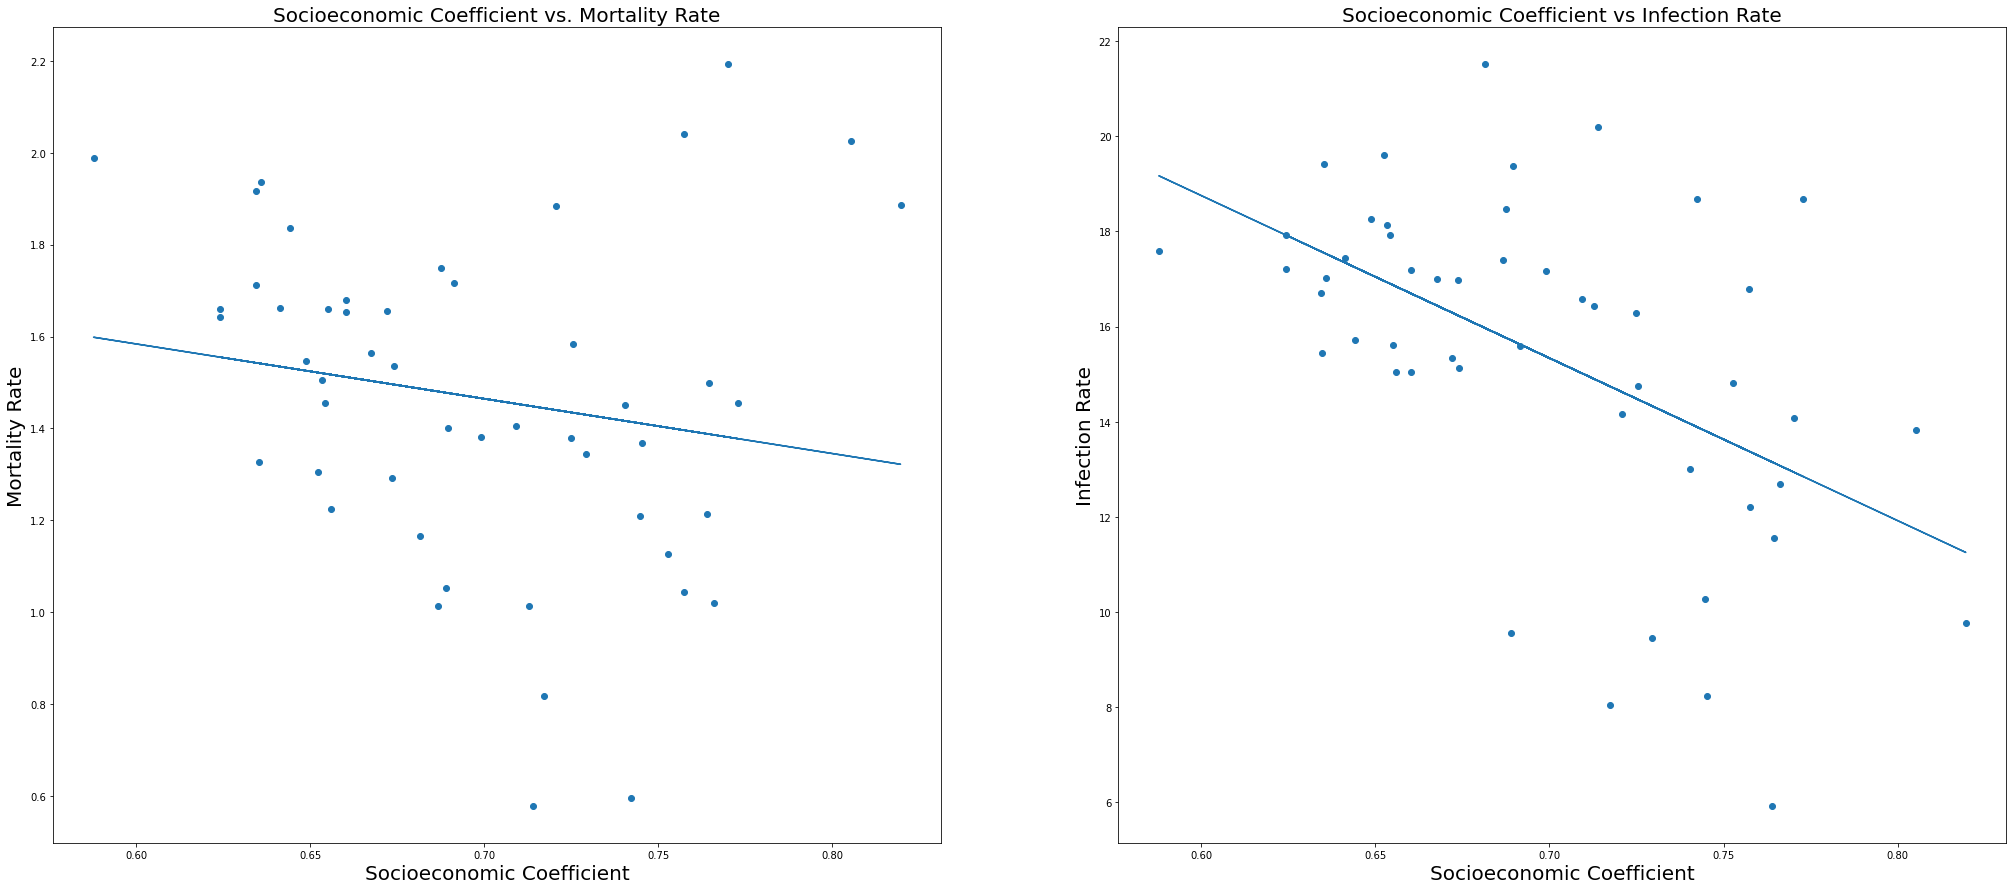

In [65]:
# clara

#initialize the figure and scatterplots
fig3 = plt.figure(figsize = (35, 15))
ax1 = fig3.add_subplot(121)
ax2 = fig3.add_subplot(122)

a1, b1 = np.polyfit(overall_df['coeff'], overall_df['%_mortality_rate'],1)
a2, b2 = np.polyfit(overall_df['coeff'], overall_df['%_infection_rate'], 1)

#integrate data from overall_df/data from all states
ax1.scatter(overall_df['coeff'], overall_df['%_mortality_rate'])
ax2.scatter(overall_df['coeff'], overall_df['%_infection_rate'])

#titles and axis labels
ax1.set_title('Socioeconomic Coefficient vs. Mortality Rate', fontsize = 20)
ax1.set_xlabel('Socioeconomic Coefficient', fontsize = 20)
ax1.set_ylabel('Mortality Rate', fontsize = 20)

ax2.set_title('Socioeconomic Coefficient vs Infection Rate', fontsize = 20)
ax2.set_xlabel('Socioeconomic Coefficient', fontsize = 20)
ax2.set_ylabel('Infection Rate', fontsize = 20)

ax1.plot(overall_df['coeff'], a1*overall_df['coeff']+b1)
ax2.plot(overall_df['coeff'], a2*overall_df['coeff']+b2)



plt.show()

### Hm... well now that we've seen the general trends in our data, let's dive into deeper analyses! Here we will begin to understand the variability in our data.

#### Linear regression for mortality rate and all socioeconomic variables

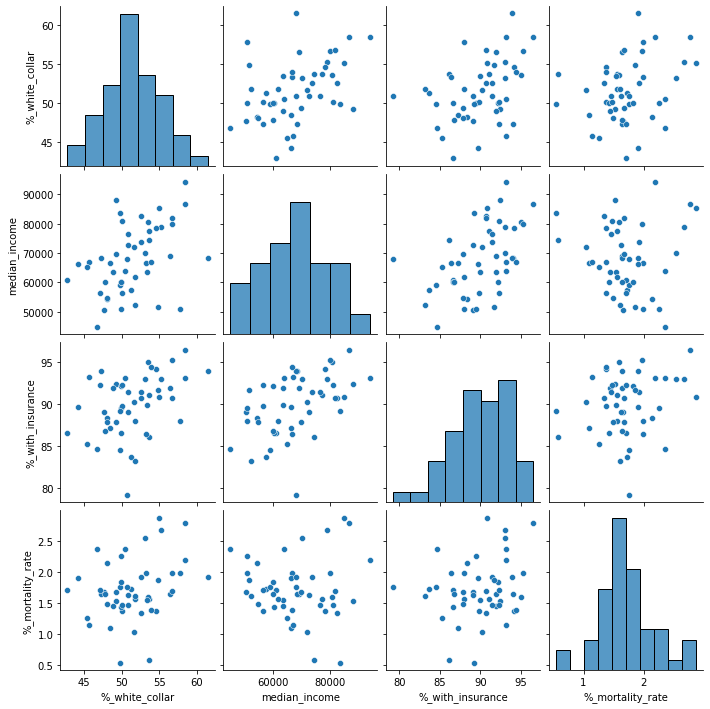

[ 3.87475647e-02 -1.04783700e-05  2.72062208e-02]


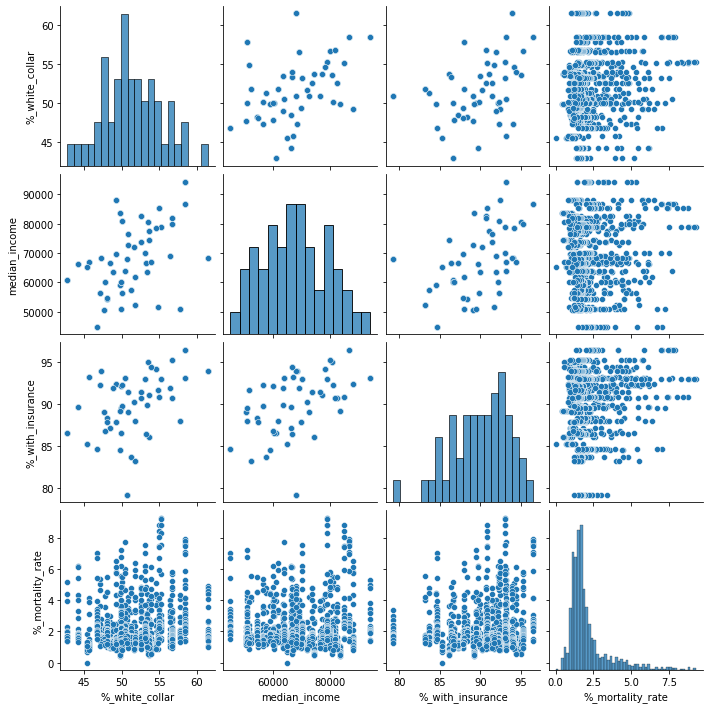

[ 5.68881972e-02 -5.50368716e-06  4.91743359e-02]


In [66]:

# 1 day worth of data
mortality_regression_data = get_overall_data(3, 12, 2021)
mortality_regression_data = mortality_regression_data[["%_white_collar", "median_income", "%_with_insurance", "%_mortality_rate"]]
# Scatterplot matrix of each data type
sns.pairplot(mortality_regression_data, kind="scatter")
plt.show()
# setup regression data
mortality_X = mortality_regression_data[["%_white_collar", "median_income", "%_with_insurance"]]
mortality_Y = mortality_regression_data["%_mortality_rate"]
# create and fit model
mortality_model = linear_model.LinearRegression()
mortality_model.fit(mortality_X, mortality_Y)
# get relationship coefficients
print(mortality_model.coef_)

# 23 days worth of data
data_points = [
    (4, 10, 2020),
    (5, 10, 2020),
    (6, 10, 2020),
    (7, 10, 2020),
    (8, 10, 2020),
    (9, 10, 2020),
    (10, 10, 2020),
    (11, 10, 2020),
    (12, 10, 2020),
    (1, 10, 2021),
    (2, 10, 2021),
    (3, 10, 2021),
    (4, 10, 2021),
    (5, 10, 2021),
    (6, 10, 2021),
    (7, 10, 2021),
    (8, 10, 2021),
    (9, 10, 2021),
    (10, 10, 2021),
    (11, 10, 2021),
    (12, 10, 2021),
    (1, 10, 2022),
    (2, 10, 2022)
]
# get data
mortality_regression_data = pd.DataFrame(columns=["%_white_collar", "median_income", "%_with_insurance", "%_mortality_rate"])

for point in data_points:
    df = get_overall_data(*point)

    df = df[["%_white_collar", "median_income", "%_with_insurance", "%_mortality_rate"]]
    mortality_regression_data = pd.concat([mortality_regression_data, df], ignore_index=True)
# generate scatterplot matrix
sns.pairplot(mortality_regression_data, kind="scatter")
plt.show()
# setup regression data
mortality_X = mortality_regression_data[["%_white_collar", "median_income", "%_with_insurance"]]
mortality_Y = mortality_regression_data["%_mortality_rate"]
# create and fit model
mortality_model = linear_model.LinearRegression()
mortality_model.fit(mortality_X, mortality_Y)
# get relationship coefficients
print(mortality_model.coef_)

We can see that as the COVID-19 pandeic went on, the data fluctuates, but for the most part, there isn't much drastic change as to the relationships between our independent variables and our dependent variable. This general trend exists that:

The more white collar workers, the mortality rate will rise.
The lower the median income, the the mortality rate will rise.
The more people with insurance, the mortality rate will rise.

#### Least Square for Mortaility Rate and Socioeconomic Variables

                            OLS Regression Results                            
Dep. Variable:       %_mortality_rate   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.7945
Date:                Fri, 25 Feb 2022   Prob (F-statistic):              0.377
Time:                        14:58:13   Log-Likelihood:                -18.757
No. Observations:                  50   AIC:                             41.51
Df Residuals:                      48   BIC:                             45.34
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0128      0.014     -0.891      0.3

Text(0.5, 1.0, 'Q-Q plot')

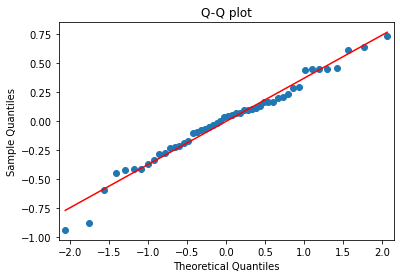

In [67]:

mortality_OLS_data = get_overall_data(12, 12, 2021)
# get least square datat
mortality_X = mortality_OLS_data[["%_white_collar", "median_income", "%_with_insurance"]]
mortality_OLS_Y = mortality_OLS_data["%_mortality_rate"]
# create variables for least square
ones = np.ones(mortality_X.shape[0])
mortality_OLS_X = sm.add_constant(np.column_stack((mortality_OLS_data["%_white_collar"], ones)))
mortality_OLS_X = sm.add_constant(np.column_stack((mortality_OLS_data["median_income"], ones)))
mortality_OLS_X = sm.add_constant(np.column_stack((mortality_OLS_data["%_with_insurance"], ones)))
# create and fit model
results = sm.OLS(mortality_OLS_Y, mortality_OLS_X).fit()
print(results.summary())
# check q-q plot to see if our results are okay
fig2 = sm.qqplot(results.resid, line='r')
plt.title("Q-Q plot")

For our least square results on mortality rate, we can see that the result points to strong multicollinearity. To verify this, we used a Q-Q plot to see and for the most part, the data points follow the straight line, with some deviations.

This would make sense as white collar jobs are typically associated with higher incomes.

From this, we can say that our independent variables are collineary and therefore since we are ultimately creating a prediction, this would not affect our final result.

#### Linear regression for infection rate and socioeconomic variables

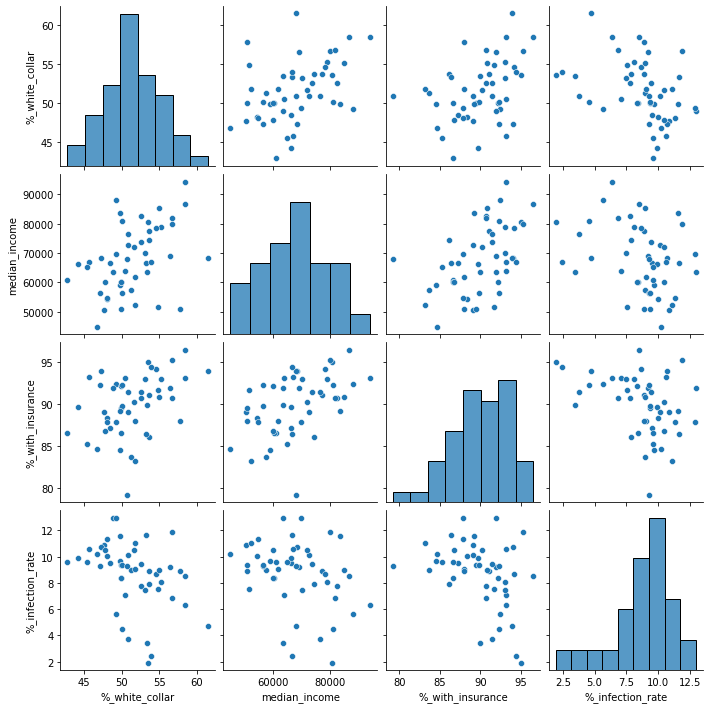

[-1.59859426e-01 -2.01989360e-05 -1.64458283e-01]


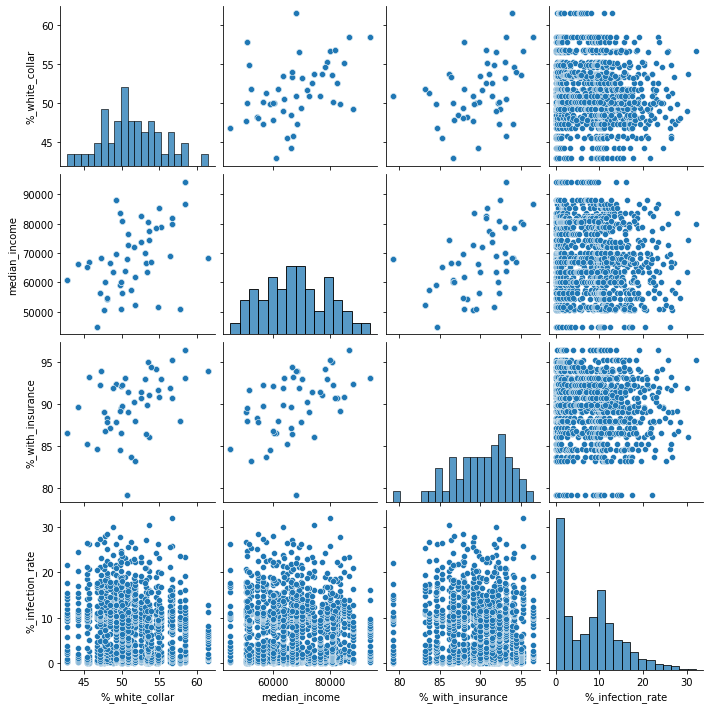

[-1.29371511e-01 -2.29572459e-05 -1.17831926e-01]


In [68]:
from sklearn import linear_model
# 1 day worth of data
infection_regression_data = get_overall_data(3, 12, 2021)
infection_regression_data = infection_regression_data[["%_white_collar", "median_income", "%_with_insurance", "%_infection_rate"]]

sns.pairplot(infection_regression_data, kind="scatter")
plt.show()


infection_X = infection_regression_data[[ "%_white_collar", "median_income", "%_with_insurance"]]
infection_Y = infection_regression_data["%_infection_rate"]

infection_model = linear_model.LinearRegression()
infection_model.fit(infection_X, infection_Y)

print(infection_model.coef_)

infection_regression_data = pd.DataFrame(columns=["%_white_collar", "median_income", "%_with_insurance", "%_infection_rate"])

for point in data_points:
    df = get_overall_data(*point)
    df = df[[ "%_white_collar", "median_income", "%_with_insurance", "%_infection_rate"]]
    infection_regression_data = pd.concat([infection_regression_data, df], ignore_index=True)
    
sns.pairplot(infection_regression_data, kind="scatter")
plt.show()

infection_X = infection_regression_data[["%_white_collar", "median_income", "%_with_insurance"]]
infection_Y = infection_regression_data["%_infection_rate"]

infection_model = linear_model.LinearRegression()
infection_model.fit(infection_X, infection_Y)

print(infection_model.coef_)

In [69]:

import statsmodels.api as sm

infection_regression_data = get_overall_data(3, 12, 2021)
infection_regression_data = infection_regression_data[["%_white_collar", "median_income", "%_with_insurance", "%_infection_rate"]]

#alternate linear regression approach
#formula = """Q('%_infection_rate') ~ Q('%_white_collar')"""

#Multivariate analsysi of infection rate with white collar, median income, and with_insurance data.
formula = """Q('%_infection_rate') ~ Q('%_white_collar') + Q('median_income') + Q('%_with_insurance')"""
data = infection_regression_data
dep, predictors = patsy.dmatrices(formula, data)
model = sm.OLS(dep, predictors)
res_1 = model.fit()
print(res_1.summary())


                              OLS Regression Results                             
Dep. Variable:     Q('%_infection_rate')   R-squared:                       0.214
Model:                               OLS   Adj. R-squared:                  0.162
Method:                    Least Squares   F-statistic:                     4.163
Date:                   Fri, 25 Feb 2022   Prob (F-statistic):             0.0109
Time:                           14:58:26   Log-Likelihood:                -110.13
No. Observations:                     50   AIC:                             228.3
Df Residuals:                         46   BIC:                             235.9
Df Model:                              3                                         
Covariance Type:               nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------


# The Best Part
One of our biggest goals coming into this project was to be able to create a predictive script that took socioeconomic factors and created a predicted morality and infection rate.

In [70]:
def prediction(median_income, with_insurance, white_collar, desired_output):
    coeff = calculate_alpha(median_income, with_insurance, white_collar)
    predicted_mortality = a1*coeff+b1
    predicted_infection = a2*coeff+b2
    if desired_output == 'mortality_rate':
        output = predicted_mortality
        output = f'{desired_output} = {output} %'
    if desired_output == 'infection_rate':
        output = predicted_infection
        output = f'{desired_output} = {output} %'
    if desired_output == 'both':
        output = [predicted_mortality,predicted_infection]
        output = f'mortality_rate = {output[0]}% \ninfection_rate = {output[1]}%'
    return(output)

# Hello user! Feel free to input any values into the prediction function to see what your "hypothetic state" would output for mortality rate and infection rate.
# The first parameter is the median income, second is the % of people w insurance, and the third is the % of workers who fall under white collar work
# The last parameter is whether you want to predict infection or mortality rate. Have fun! Max median income is 100,000.

# user_input = prediction(0, 0, 0, 'mortality_rate')
# print(user_input)

#AN EXAMPLE!
clarafornia = prediction(100000, 90, 50, 'both')
# print(clarafornia)

ernestopia = prediction(2, 2, 2, 'both')
print(ernestopia)

ethantinople = prediction(50000, 20, 40, 'both')

wesafrica = prediction(70000, 60, 20, 'both')

stephenopolis = prediction(100000,100,100,'both')
# print(stephenopolis)

mortality_rate = 2.2842289061649383% 
infection_rate = 38.79509497852222%
